In [ ]:
import sys
sys.path.append('sources')
import traceback
import os
import json

# Choose the test
All the test available are in folder 'CPIs'

In [ ]:
process_name = "test0" #choice-task-init-reverse

## Load File 

In [ ]:
cpi_file_path = f'CPIs/{process_name}.cpi'

print(f"Loading CPI file: {cpi_file_path}")

try:
	with open(cpi_file_path, 'r') as f:
		cpi_dict = json.load(f)

	print("✓ CPI file loaded successfully!")
	print(f"Root region type: {cpi_dict['type']}")
	print(f"Root region ID: {cpi_dict['id']}")

	# Pretty print the CPI structure
	print("\nCPI Structure:")
	print("=" * 50)
	print(json.dumps(cpi_dict, indent=2))

except FileNotFoundError:
	print(f"❌ File not found: {cpi_file_path}")
	print("Available files in CPIs directory:")
	try:
		for f in os.listdir('CPIs'):
			if f.endswith('.cpi'):
				print(f"  - {f}")
	except:
		print("  Could not list CPIs directory")
except Exception as e:
	print(f"❌ Error loading CPI file: {e}")
	traceback.print_exc()

# FROM CPI TO SPIN

In [ ]:
from cpi_to_mdp.cpitospin import analyze_cpi_structure, CPIToSPINConverter

print("\nCPI Structure Analysis:")
print("=" * 50)
if 'cpi_dict' in locals():
	analyze_cpi_structure(cpi_dict)

print("Converting CPI to SPIN...")
print("=" * 50)

try:
	converter = CPIToSPINConverter()
	spin_model = converter.convert_cpi_to_spin(cpi_dict)

	print("✓ Conversion successful!")
	print("\nSPIN Model Summary:")
	print("-" * 30)
	spin_model.print_model_summary()

except Exception as e:
	print(f"❌ Conversion failed: {e}")
	traceback.print_exc()

## Process Visualization

The CPI dictionary can be visualized as a directed graph to better understand its structure. In this visualization:

- **Task nodes** show duration and impact values (cost, time, quality)
- **Nature nodes** display their probability values (e.g., "p=0.7")
- **Sequence nodes** connect components with "head" and "tail" edges
- **Parallel nodes** show concurrent branches with "first" and "second" edges
- **Choice nodes** represent decision points with "true" and "false" branches

Each node type is represented as a box, with edges showing the relationships between components. This hierarchical representation helps understand the process flow and decision points in the system.

In [ ]:
from cpi_to_mdp.cpitospin import create_cpi_visualization, create_spin_visualization

print("\nCreating visualizations...")
print("=" * 50)

try:
	# Create CPI visualization
	cpi_viz = create_cpi_visualization(cpi_dict, "CPI: Loop Example")
	print("✓ CPI visualization created")

	# Create SPIN visualization
	spin_viz = create_spin_visualization(spin_model, "SPIN: Loop Example")
	print("✓ SPIN visualization created")

	# Display visualizations (if in Jupyter)
	try:
		print("\nCPI Structure Visualization:")
		display(cpi_viz)

		print("\nSPIN Model Visualization:")
		display(spin_viz)
	except NameError:
		# Not in Jupyter, save to files instead
		print("Saving visualizations to files...")

		# Save CPI visualization
		cpi_output = process_name + '_cpi'
		cpi_viz.render(cpi_output, cleanup=True)
		print(f"CPI visualization saved to: {cpi_output}.png")

		# Save SPIN visualization
		spin_output = process_name + '_spin'
		spin_viz.render(spin_output, cleanup=True)
		print(f"SPIN visualization saved to: {spin_output}.png")

except Exception as e:
	print(f"❌ Visualization failed: {e}")
	traceback.print_exc()


# FROM SPIN TO PRISM

In [ ]:
print("\nGenerating PRISM model...")
print("=" * 50)

try:
	prism_model = spin_model.generate_prism_model()

	print("✓ PRISM model generated successfully!")

	# Show model statistics
	lines = prism_model.split('\n')
	words = prism_model.split()

	print(f"Model statistics:")
	print(f"  Lines: {len(lines)}")
	print(f"  Words: {len(words)}")
	print(f"  Characters: {len(prism_model)}")

	# Show first 20 lines
	print(f"\nFirst 20 lines of PRISM model:")
	print("-" * 40)
	for i, line in enumerate(lines[:20]):
		print(f"{i + 1:2d}: {line}")

	if len(lines) > 20:
		print(f"... ({len(lines) - 20} more lines)")

except Exception as e:
	print(f"❌ PRISM generation failed: {e}")
	traceback.print_exc()

print("\nSaving PRISM model...")
print("=" * 50)

try:
	output_file =  "models/" + process_name + '.nm'
	with open(output_file, 'w') as f:
		f.write(prism_model)

	print(f"✓ PRISM model saved to: {output_file}")

	# Verify file was created
	if os.path.exists(output_file):
		file_size = os.path.getsize(output_file)
		print(f"File size: {file_size} bytes")
	else:
		print("❌ Warning: File was not created")

except Exception as e:
	print(f"❌ Save failed: {e}")
	traceback.print_exc()

## RUN PRISM ANALYSIS

In [ ]:
!prism

In [ ]:
from env import PRISM_PATH
from prism import run_prism_analysis

prism_path = None # If PRISM_PATH is set in the environment
#prism_path = PRISM_PATH
run_prism_analysis(process_name, create_mdp=True)


### Read output

In [ ]:
from graphviz import Source

dot_filename = f"models/{process_name}.dot"

with open(dot_filename, 'r', encoding='utf-8') as f: #{process_name}/{process_name}.dot
    dot_content = f.read()
    Source(dot_content).render(filename=f"models/{process_name}", format='svg', cleanup=True)

states_filenames = f"models/{process_name}_states.csv"
transitions_filenames = f"models/{process_name}_trans.tra"

# FROM PRISM TO MDP

Since PRISM models are based on an extended form of MDPs, we now provide the compact version of the MDP generated by PRISM, which corresponds to the equivalent SPIN model. This enhances clarity and facilitates easier comparison between the two representations.

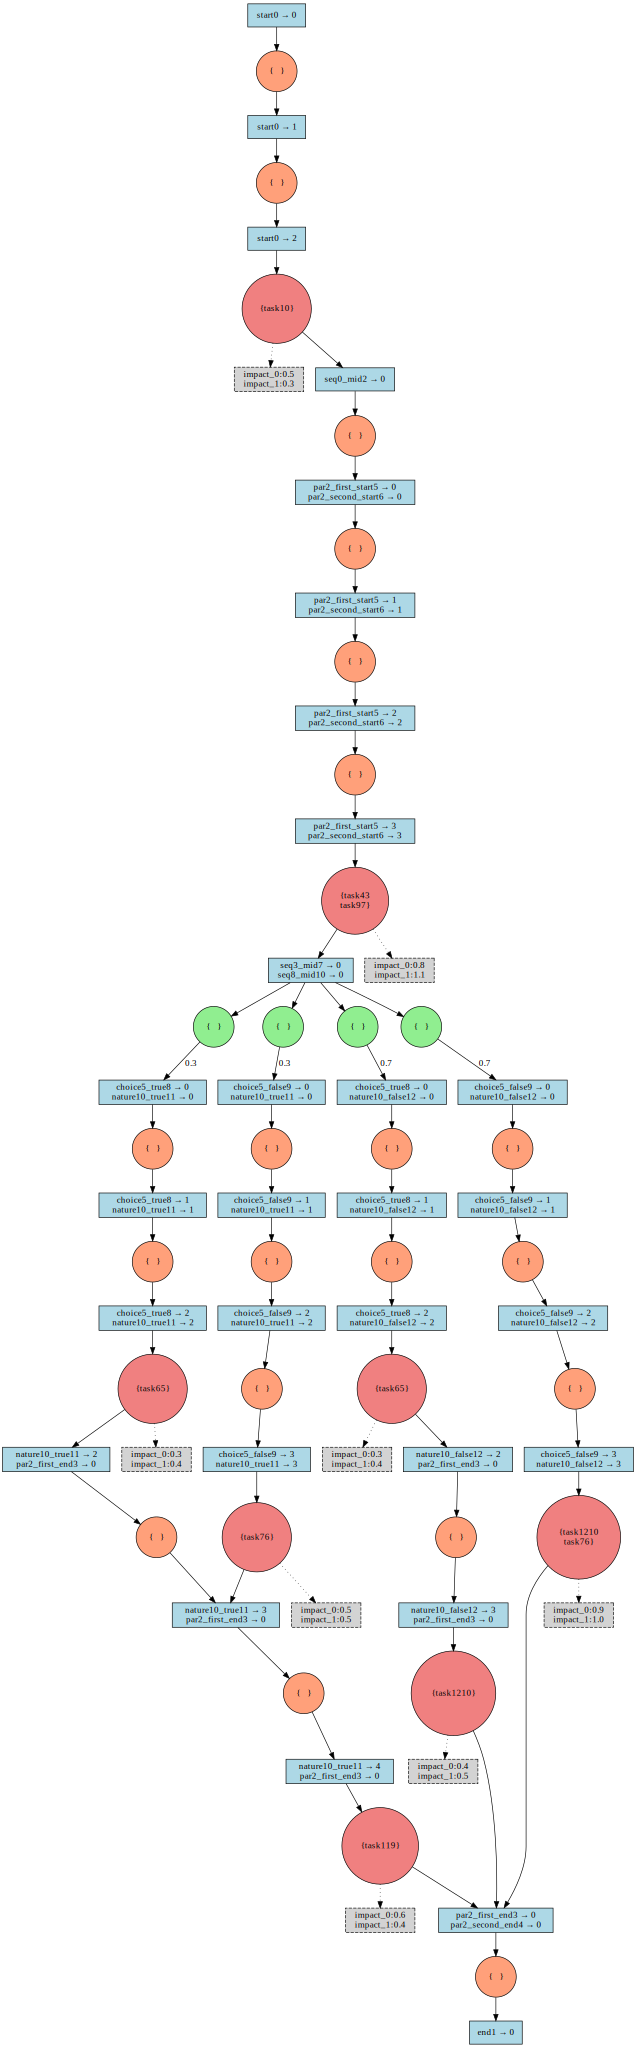

In [35]:
from graphviz import Source
from collections import defaultdict
import pandas as pd
import re

def get_compact_states(states: pd.DataFrame, transitions: pd.DataFrame):
    # Extracts the innermost value from the '(STAGE' column (e.g., "Stage:(2:1)" -> "1")
    states['STAGE'] = states['(STAGE'].apply(
        lambda x: x.split(':')[-1].split('(')[-1] if isinstance(x, str) else x
    )
    # Drops the original '(STAGE' column after processing
    states.drop(columns=['(STAGE'], inplace=True)

    # Identify columns with names ending in ')' — these often contain extraneous characters
    paren_cols = [col for col in states.columns if col.endswith(')')]
    
    for col in paren_cols:
        # Replace the column (without closing paren) with the second-to-last character of the value, if valid
        states[col.replace(')', '')] = states[col].apply(
            lambda x: x[-2] if isinstance(x, str) and len(x) >= 2 else x
        )
        # Drop the original column with ')'
        states.drop(columns=[col], inplace=True)

    # Convert all columns to numeric types (errors will become NaN)
    states = states.apply(pd.to_numeric)

    # Identify relevant columns for updates, states, and values
    update_cols = [col for col in states.columns if col.endswith('_update')]
    state_cols = [col for col in states.columns if col.endswith('_state')]
    value_cols = [col for col in states.columns if col.endswith('_value')]  # unused in current logic

    # Create a mask for rows that are at the beginning of a stage (STAGE == 0)
    stage_mask = states['STAGE'].isin([0])    
    # Create a mask for rows where all '_update' columns are 0
    update_mask = (states[update_cols] == 0).all(axis=1)    
    # Create a mask for rows where all '_state' columns are 0
    state_mask = (states[state_cols] == 0).all(axis=1)
    new_states_df = states[stage_mask & update_mask & state_mask]
    # Return filtered DataFrame based on all masks
    return new_states_df, set(new_states_df.index.astype(int).tolist()), value_cols

def format_label(row, value_cols):
    parts = [
        f"{col.replace('_value', '')} → {int(row[col])}"
        for col in value_cols if row[col] >= 0
    ]
    joined_parts = '\n'.join(parts)
    return f'{row.name} [label="{joined_parts}", style="filled", fillcolor="lightblue"];'

def create_trans_dict(transitions:pd.DataFrame, verbose = False):
    trans = transitions[0].str.split(expand=True)
    if verbose:
        print(trans.head())
        print(trans.shape)
    # Check if 'prob' column exists (based on column count)
    has_prob = trans.shape[1] >= 5
    
    # Extract relevant columns
    if has_prob:
        source_dest = trans[[0, 2, 3, 4]]
        source_dest.columns = ['source', 'destination', 'prob', 'label']
    else:
        source_dest = trans[[0, 2, 3]]
        source_dest.columns = ['source', 'destination', 'label']
    # Create dictionary: {source: [(destination, prob)]} or {source: [(destination,)]}
    trans_dict = defaultdict(list)
    
    for _, row in source_dest.iterrows():
        source = int(row['source'])
        destination = int(row['destination'])
        prob = float(row['prob']) if has_prob else 1.0  # Default prob to 1.0 if missing
        label = [row['label'] ]if row['label'] else []
        trans_dict[source].append((destination, prob,label))
    
    # Optional: convert to regular dict
    return dict(trans_dict)

def find_next_state(src:int, trans_dict:dict, possible_targets: set, verbose = False):  
        res = []
        for i in range(len(trans_dict[src])):
            if src == trans_dict[src][i][0]:
                return [] # it's final 
            if trans_dict[src][i][0] in possible_targets:
                if verbose:
                    print(trans_dict[src][i][0], trans_dict[src][i][1])
                res.append(trans_dict[src][i]) # questo significa che src e target sono collegati direttamente 
            
        if len(res) > 0:
            return res
        for i in range(len(trans_dict[src])): 
            # continua a cercare ma la destinazione è diventata source
            l = trans_dict[src][i][2]
            for r in find_next_state( trans_dict[src][i][0], trans_dict, possible_targets):
                l.extend(r[2])
                res.append((r[0], round(r[1] * trans_dict[src][i][1], 3), l))            
        return res

def parse_rewards_file(filepath):
    rewards_dict = defaultdict(dict)
    current_impact = None

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Start of a reward block
            if line.startswith('rewards'):
                match = re.search(r'rewards\s+"([^"]+)"', line)
                if match:
                    current_impact = match.group(1)

            # End of a reward block
            elif line == 'endrewards':
                current_impact = None

            # Inside a reward block
            elif current_impact:
                match = re.match(r'\[([^\]]+)\]\s+true\s*:\s*([0-9.eE+-]+);', line)
                if match:
                    task_name = match.group(1)
                    value = float(match.group(2))
                    rewards_dict[task_name][current_impact] = value

    return dict(rewards_dict)

def fromat_label_impacts_impactslabel(label: list, rewards_dict: dict):
    l = []
    impact_sums = {}  # Accumulate sums for each impact
    
    for col in label:
        l.append(f"{col.replace('fire_', '')}")
        for impact, value in rewards_dict[col].items():
            if impact in impact_sums:
                impact_sums[impact] += value
            else:
                impact_sums[impact] = value

    # Format summed impacts as "impact_name:total_value"
    lab_impacts = [f'{impact}:{value}' for impact, value in impact_sums.items()]
    return '\n'.join(l), '\n'.join(lab_impacts)
    
def create_states_mdp(states:pd.DataFrame, transitions:pd.DataFrame, process_name = 'test0', save =False):
    
    new_states_df, possible_targets, value_cols = get_compact_states(states, transitions)
    trans_dict = create_trans_dict(transitions)
    rewards_dict = parse_rewards_file(f"models/{process_name}.nm")
    lines = ['digraph LTS {', 'node [label="", shape="box"];']

    idx_trans = max(possible_targets)+1  
    for idx, row in new_states_df.iterrows():
        lines.append(format_label(row, value_cols)) # add node states
        targets = find_next_state(idx, trans_dict, possible_targets)
        for t in targets:
            next_idx, probability, label = t
            prob_label = f'[label = ""]'
            if label:
                l , lab_impacts = fromat_label_impacts_impactslabel(label, rewards_dict)
                color = "lightcoral"
                if probability < 1.0:   
                    prob_label = f'[label = "{probability}"]'
                    color="lightgreen"          
                lines.append(f'{idx_trans} [label="{{{l}}}" , style="filled", fillcolor={color}, shape="circle" ];')   
                # Create the label node (square)
                label_node_id = f'label_{idx_trans}'
                lines.append(f'{label_node_id} [label="{lab_impacts}", shape="box", style="filled,dashed", fillcolor="lightgrey"];')
                
                # Link it to the main node with a dotted edge
                lines.append(f'{idx_trans} -> {label_node_id} [style="dotted"];')
            else:
                color = "lightsalmon"
                if probability < 1.0:   
                    prob_label = f'[label = "{probability}"]'
                    color="lightgreen"  
                lines.append(f'{idx_trans} [label="{{∅}}" , style="filled", fillcolor={color}, shape="circle"];')         
            
            lines.append(f'{idx} -> {idx_trans};')
            lines.append(f'{idx_trans} -> {next_idx} {prob_label}; ')
            idx_trans +=1
    lines.append('}')
    compress_dot = "\n".join(lines)
    if save:
        Source(compressed_dot).render(filename=f"models/{process_name}_cleaned", format='svg', cleanup=True)
    return compress_dot


states = pd.read_csv(states_filenames)
transitions = pd.read_csv(transitions_filenames, skiprows=1, header= None)

compressed_dot = create_states_mdp(states, transitions)

#print(compressed_dot)
Source(compressed_dot)

In [ ]:
states

In [ ]:
transitions

In [ ]:
    # idx_prec = 0
    # for idx, row in new_states_df.iterrows():
    #     # if str(idx) not in nodes_to_remove:
    #     lab = format_label(row)
    #     lines.append(lab) 
    #     targets = find_next_state(idx, trans_dict, new_state_set)
    #     for t in targets:
    #         next_idx, probability, label = t
    #         prob_label = f'[label = ""]'
    #         if probability < 1.0:
    #             prob_label = f'[label = "{probability}"]'
    #         if label and probability < 1.0:
    #             l = [f"{col.replace('fire_', '')}" for col in label ]
    #             l = '\n'.join(l)
    #             try:
    #                 lines.remove(f'{idx_trans-1} [label="{{∅}} " , style="filled", fillcolor="lightgreen", shape="circle" ];')
    #             except Exception as e:
    #                 lines.append(f'{idx_trans} [label="{{∅}}" , style="filled", fillcolor="lightsalmon", shape="circle"];')  
    #             lines.append(f'{idx_trans-1} [label=" {{{l}}} " , style="filled", fillcolor="lightgreen", shape="circle" ];')
                
    #         elif label:
    #             l = [f"{col.replace('fire_', '')}" for col in label ]
    #             l = '\n'.join(l)
    #             try:
    #                 lines.remove(f'{idx_trans-1} [label="{{∅}} " , style="filled", fillcolor="lightgreen", shape="circle" ];')
    #             except Exception as e:
    #                 lines.append(f'{idx_trans} [label="{{∅}}" , style="filled", fillcolor="lightsalmon", shape="circle"];')  
    #             lines.append(f'{idx_trans-1} [label="{{{l}}}" , style="filled", fillcolor="lightcoral", shape="circle" ];')
                
            
    #         if probability < 1.0:
    #             lines.append(f'{idx_trans} [label="{{∅}} " , style="filled", fillcolor="lightgreen", shape="circle" ];')
    #         else:
    #             lines.append(f'{idx_trans} [label="{{∅}}" , style="filled", fillcolor="lightsalmon", shape="circle"];')         
            
    #         lines.append(f'{idx} -> {idx_trans};')
    #         lines.append(f'{idx_trans} -> {next_idx} {prob_label}; ')
    #         idx_trans +=1
    #         idx_prec = idx